## Part B4 - Price Modeling by Sampling

### 4.1 - Import Libraries & Loading Data

In [47]:
# Cell 1: Import libraries and configure environment

# --- Core Libraries ---
import pandas as pd
import numpy as np
import random
import warnings
from datetime import datetime

# --- Scikit-learn: Data Preparation & Modeling ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Progress Bar ---
from tqdm import tqdm
tqdm.pandas()

# --- Warnings ---
warnings.simplefilter("ignore", ConvergenceWarning)


### 4.2 - Data Preproseccing

pp

In [48]:
def load_and_filter_data(csv_path):

    # Step 1: Load raw data
    df = pd.read_csv(csv_path)
    print("Step 1 - Initial rows:", df.shape[0])

    # Step 2: Remove rows with missing Discount Price
    df = df[df['Discount Price'].notna()]
    print("Step 2 - After removing missing Discount Price:", df.shape[0])

    # Step 3: Keep top 40 hotels with the most data
    top_40_hotels = df['Hotel Name'].value_counts().head(40).index
    df = df[df['Hotel Name'].isin(top_40_hotels)]
    print("Step 3 - After keeping only top 40 hotels:", df.shape[0])

    # Step 4: Filter to only include rows within 30 days
    df = df[df['DayDiff'] <= 30]
    print("Step 4 - After filtering DayDiff ≤ 30:", df.shape[0])

    # Step 5: Group by hotel, snapshot date and discount code
    grouped = df.groupby(['Hotel Name', 'Snapshot Date', 'Discount Code']).size().reset_index(name='Count')
    print("Step 5 - Total groups after grouping:", grouped.shape[0])

    # Step 6: Keep only groups with at least 5 samples
    grouped = grouped[grouped['Count'] >= 5].copy()
    print("Step 6 - Groups with Count ≥ 5:", grouped.shape[0])

    # Step 7: Sort by Count descending and reset index
    grouped = grouped.sort_values(by='Count', ascending=False).reset_index(drop=True)

    # Step 8: Preview top 10 groups
    print("\nTop 10 groups with the highest number of samples:")
    display(grouped.head(10))

    return df, grouped


# Load and process data
df, grouped = load_and_filter_data("Data/Hotels_data_Changed.csv")


Step 1 - Initial rows: 187848
Step 2 - After removing missing Discount Price: 187848
Step 3 - After keeping only top 40 hotels: 101564
Step 4 - After filtering DayDiff ≤ 30: 88700
Step 5 - Total groups after grouping: 19224
Step 6 - Groups with Count ≥ 5: 7503

Top 10 groups with the highest number of samples:


,Hotel Name,Snapshot Date,Discount Code,Count
0,Park Hyatt New York,2015-07-22,3,44
1,Park Hyatt New York,2015-07-22,2,43
2,The New York EDITION,2015-07-27,2,30
3,The New York EDITION,2015-07-29,3,30
4,The New York EDITION,2015-07-29,2,30
5,The New York EDITION,2015-07-27,3,30
6,Newark Liberty International Airport Marriott,2015-07-23,3,30
7,Park Hyatt New York,2015-07-22,1,30
8,Newark Liberty International Airport Marriott,2015-07-22,3,30
9,The New York EDITION,2015-07-28,3,29


### 4.3 - Train model & Feature

#### 4.3.1 - Feature 

In [49]:
# Cell 3: Feature Engineering, Split & Normalization

def feature_engineering(df):
    df = df.copy()

    # Convert to datetime & create ordinal version of Checkin Date
    df['Checkin Date'] = pd.to_datetime(df['Checkin Date'])
    df['Checkin_Ordinal'] = df['Checkin Date'].map(pd.Timestamp.toordinal)

    # Weekday mapping
    weekday_map = {
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
        'Friday': 4, 'Saturday': 5, 'Sunday': 6
    }
    df['Weekday_Num'] = df['WeekDay'].map(weekday_map)

    # Drop unused columns
    drop_cols = ['Snapshot ID', 'Checkin Date', 'WeekDay']
    df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

    return df

def normalize(df, features_to_scale, scaler=None):
    df_scaled = df.copy()
    if scaler is None:
        scaler = StandardScaler()
        df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])
    else:
        df_scaled[features_to_scale] = scaler.transform(df_scaled[features_to_scale])
    return df_scaled, scaler

# === Step 1: Feature Engineering ===
df_engineered = feature_engineering(df)

# === Step 2: Filter to valid groups (at least 5 samples per group) ===
valid_groups = grouped[['Hotel Name', 'Snapshot Date', 'Discount Code']]
merged_df = pd.merge(df_engineered, valid_groups, on=['Hotel Name', 'Snapshot Date', 'Discount Code'], how='inner')

# === Step 3: Split to train/test (raw, before normalization) ===
train_df_raw, test_df_raw = train_test_split(
    merged_df,
    test_size=0.2,
    random_state=42,
    stratify=merged_df['Hotel Name']
)

# === Step 4: Normalization ===
features_to_scale = [
    "Checkin_Ordinal", "Original Price", "Discount Price",
    "Available Rooms", "DayDiff", "DiscountDiff", "DiscountPerc"
]

train_df, fitted_scaler = normalize(train_df_raw, features_to_scale)
test_df, _ = normalize(test_df_raw, features_to_scale, scaler=fitted_scaler)

# === Output ===
print("Feature engineering, splitting & normalization completed.")
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape    : {test_df.shape}")


# Cell 4: (Deprecated – already handled in Cell 3)
# No need to repeat split/normalization again.
# This cell is intentionally left empty to avoid duplication.


Feature engineering, splitting & normalization completed.
Training set shape: (48516, 13)
Test set shape    : (12129, 13)


#### 4.3.2 - train model

In [ ]:
# Cell 4: Base Model With Evaluation (Train + Test)

from sklearn.metrics import mean_squared_error, mean_absolute_error


def base_model_with_evaluation(grouped_df, train_df, test_df, sample_size=10):
    results = []

    for _, row in tqdm(grouped_df.iterrows(), total=grouped_df.shape[0], desc="Training Base Model (With Evaluation)"):
        hotel = row['Hotel Name']
        snapshot_date = pd.to_datetime(row['Snapshot Date'])
        discount_code = row['Discount Code']

        # Train group
        train_group = train_df[
            (train_df['Hotel Name'] == hotel) &
            (pd.to_datetime(train_df['Snapshot Date']) == snapshot_date) &
            (train_df['Discount Code'] == discount_code)
        ].copy()

        # Test group
        test_group = test_df[
            (test_df['Hotel Name'] == hotel) &
            (pd.to_datetime(test_df['Snapshot Date']) == snapshot_date) &
            (test_df['Discount Code'] == discount_code)
        ].copy()

        if train_group.empty or test_group.empty:
            continue

        if train_group.shape[0] < sample_size or test_group.shape[0] < 3:
            continue

        feature_candidates = [
            'Checkin_Ordinal', 'Weekday_Num', 'Available Rooms',
            'DayDiff', 'Original Price', 'DiscountDiff', 'DiscountPerc'
        ]
        selected_features = [f for f in feature_candidates if f in train_group.columns]

        # Sampled data for fitting
        sample = train_group.sample(n=sample_size, random_state=42)
        X_sample = sample[selected_features]
        y_sample = sample['Discount Price']

        # Full sets for evaluation
        X_train = train_group[selected_features]
        y_train = train_group['Discount Price']
        X_test = test_group[selected_features]
        y_test = test_group['Discount Price']

        model = LinearRegression()
        model.fit(X_sample, y_sample)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        results.append({
            'Hotel Name': hotel,
            'Snapshot Date': snapshot_date,
            'Discount Code': discount_code,
            'Train Size': len(X_train),
            'Test Size': len(X_test),
            'Num Samples Used': sample_size,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train MAE': train_mae,
            'Test MAE': test_mae
        })

    return pd.DataFrame(results)


In [ ]:
# Cell 5: Run base model with evaluation on grouped data

# Run base model evaluation using train/test sets
base_model_results = base_model_with_evaluation(grouped, train_df, test_df, sample_size=10)
print("Base model evaluation completed.")

Training Base Model (With Evaluation): 100%|██████████| 7503/7503 [02:56<00:00, 42.54it/s]

Base model evaluation completed.


📊 Base Model Performance Summary:
📦 Total models trained: 431
🔹 Average Train R²: 0.9411
🔹 Average Test  R²: 0.8238
🔹 Average Train MAE: 0.00
🔹 Average Test  MAE: 0.01

✅ Good models: 413
❌ Bad models : 18

📈 Statistical Comparison Between Good and Bad Models:


,Good Mean,Good Std,Bad Mean,Bad Std
Train R²,0.952297,0.317083,0.683663,0.506940
Test R²,0.925746,0.253950,-1.515594,3.683113
Train MAE,0.002738,0.016695,0.020670,0.037103
Test MAE,0.001553,0.010408,0.163407,0.134139
Train Size,13.409201,3.320956,15.611111,2.500327
Test Size,4.171913,1.440397,5.000000,1.878673


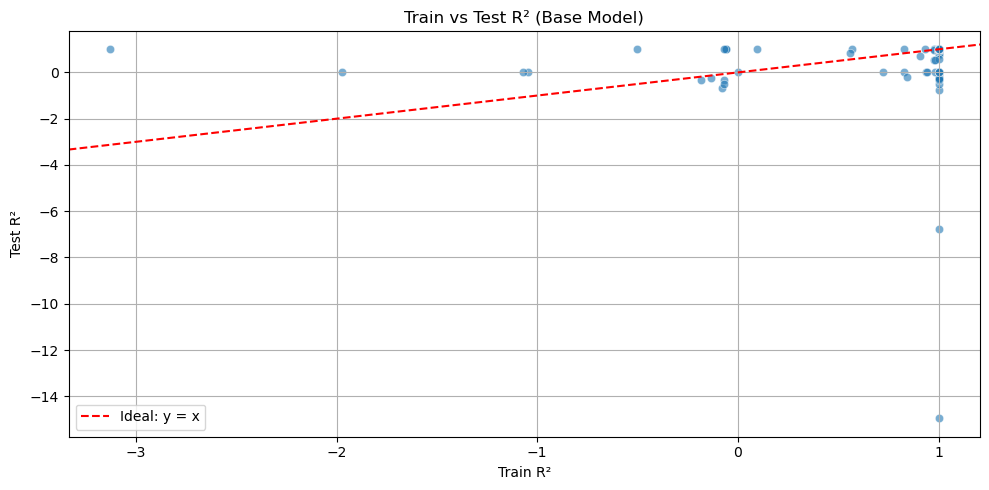

❌ Error while plotting or enriching data: Unable to allocate 21.1 PiB for an array with shape (2976146860609497,) and data type float64


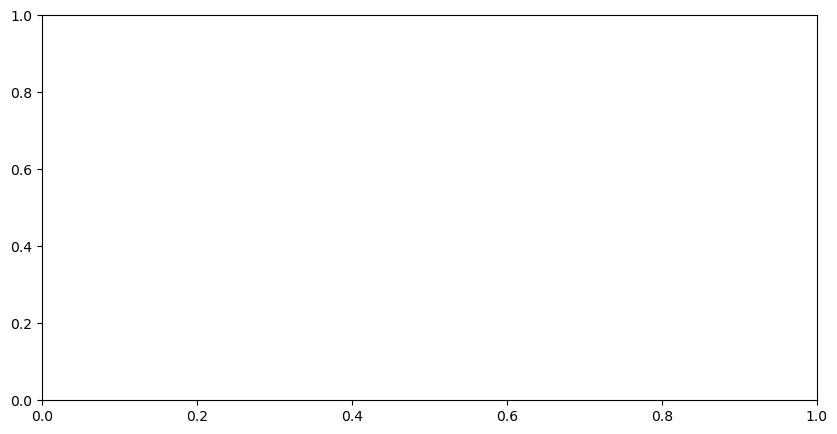

In [59]:
# Cell 6+7: Analyze Base Model Results & Enrich with Features

if base_model_results is not None and not base_model_results.empty:
    
    avg_train_r2 = base_model_results['Train R²'].mean()
    avg_test_r2 = base_model_results['Test R²'].mean()
    avg_train_mae = base_model_results['Train MAE'].mean()
    avg_test_mae = base_model_results['Test MAE'].mean()

    print(f"📊 Base Model Performance Summary:")
    print(f"📦 Total models trained: {len(base_model_results)}")
    print(f"🔹 Average Train R²: {avg_train_r2:.4f}")
    print(f"🔹 Average Test  R²: {avg_test_r2:.4f}")
    print(f"🔹 Average Train MAE: {avg_train_mae:.2f}")
    print(f"🔹 Average Test  MAE: {avg_test_mae:.2f}")

    good_models = base_model_results[base_model_results['Test R²'] >= 0].copy()
    bad_models = base_model_results[base_model_results['Test R²'] < 0].copy()

    print(f"\n✅ Good models: {len(good_models)}")
    print(f"❌ Bad models : {len(bad_models)}")

    numeric_cols = ['Train R²', 'Test R²', 'Train MAE', 'Test MAE', 'Train Size', 'Test Size']
    good_stats = good_models[numeric_cols].describe().T
    bad_stats = bad_models[numeric_cols].describe().T

    comparison = pd.concat([good_stats[['mean', 'std']], bad_stats[['mean', 'std']]], axis=1)
    comparison.columns = ['Good Mean', 'Good Std', 'Bad Mean', 'Bad Std']

    print("\n📈 Statistical Comparison Between Good and Bad Models:")
    display(comparison)

    # --- Visualization: R² train vs test ---
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=base_model_results, x='Train R²', y='Test R²', alpha=0.6)
    plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal: y = x')
    plt.title('Train vs Test R² (Base Model)')
    plt.xlabel('Train R²')
    plt.ylabel('Test R²')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Visualization: MAE distributions ---
    plt.figure(figsize=(10, 5))

    # Check if the data is valid and not too large
    try:
        # Sample a subset of the data if it's too large
        if len(base_model_results) > 10000:
            sample_data = base_model_results.sample(n=10000, random_state=42)  # Sample 10,000 rows
        else:
            sample_data = base_model_results

        # Plot histograms without KDE
        sns.histplot(sample_data['Train MAE'], color='blue', label='Train MAE', kde=False, stat='density')
        sns.histplot(sample_data['Test MAE'], color='orange', label='Test MAE', kde=False, stat='density')

        plt.title('MAE Distribution – Train vs Test')
        plt.xlabel('Mean Absolute Error')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # --- Enrich with Features Section ---
        
        def enrich_results(subset, label):
            # Ensure Snapshot Date is in datetime format on both sides
            subset = subset.copy()
            subset['Snapshot Date'] = pd.to_datetime(subset['Snapshot Date'])
            df_engineered_copy = df_engineered.copy()
            df_engineered_copy['Snapshot Date'] = pd.to_datetime(df_engineered_copy['Snapshot Date'])

            merged = pd.merge(
                subset[['Hotel Name', 'Snapshot Date', 'Discount Code']],
                df_engineered_copy,
                on=['Hotel Name', 'Snapshot Date', 'Discount Code'],
                how='left'
            )
            merged['Performance'] = label
            return merged

        # Enrich both groups
        good_data = enrich_results(good_models, 'Good')
        bad_data = enrich_results(bad_models, 'Bad')

        # Merge for further comparison
        merged_all = pd.concat([good_data, bad_data], ignore_index=True)
        print("✅ Enrichment complete. Combined shape:", merged_all.shape)

    except Exception as e:
        print(f"❌ Error while plotting or enriching data: {e}")

else:
    print("❌ base_model_results is empty or not defined.")

### 4.6 - Active Sampling (GPR)

In [90]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
from tqdm import tqdm


def build_gpr_model(noise_level=0.1):
    """
    Build a Gaussian Process Regressor with optimized hyperparameters.
    
    Added WhiteKernel to handle noisy data better and prevent overfitting.
    """
    # Use more robust kernel with explicit noise handling
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=noise_level)
    
    return GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=9,  # Increased from 5 to find better optima
        alpha=0.1,  # Increased regularization to prevent overfitting
        normalize_y=True,
        random_state=42
    )


def active_sampling(X, y, max_samples=15, batch_size=3, uncertainty_threshold=0.1):
    """
    Perform active sampling to select the most informative training points.
    
    Args:
        X: Features DataFrame
        y: Target Series
        max_samples: Maximum number of samples to select
        batch_size: Number of samples to add in each iteration
        uncertainty_threshold: Minimum uncertainty to continue sampling
        
    Returns:
        Dictionary with trained model, selected indices, and number of samples
    """
    n_samples = X.shape[0]
    
    # Use more robust initial sampling - evenly spaced points
    if n_samples >= 5:
        # Select 5 evenly spaced points for better coverage
        initial_indices = [int(i * (n_samples-1) / 4) for i in range(5)]
        training_indices = set(initial_indices)
    else:
        # If we have fewer than 5 samples, use all of them
        training_indices = set(range(n_samples))
    
    candidate_indices = set(range(n_samples)) - training_indices
    max_samples = min(max_samples, n_samples)

    # Early exit if we don't have enough data
    if n_samples <= 5:
        X_final = X.iloc[sorted(training_indices)]
        y_final = y.iloc[sorted(training_indices)]
        final_model = build_gpr_model(noise_level=0.5)  # Higher noise for small datasets
        final_model.fit(X_final, y_final)
        return {
            'model': final_model,
            'indices': sorted(training_indices),
            'num_samples': len(training_indices)
        }

    # Iteratively add most uncertain points
    iteration = 0
    max_iterations = 10  # Limit iterations to prevent infinite loops
    
    while len(training_indices) < max_samples and candidate_indices and iteration < max_iterations:
        iteration += 1
        X_train = X.iloc[sorted(training_indices)]
        y_train = y.iloc[sorted(training_indices)]

        # Fit model on current training set with different noise levels based on dataset size
        noise_level = 0.5 if len(training_indices) < 10 else 0.1
        model = build_gpr_model(noise_level=noise_level)
        
        try:
            model.fit(X_train, y_train)
            
            # Predict uncertainty for remaining candidates
            candidate_list = sorted(candidate_indices)
            X_candidates = X.iloc[candidate_list]
            
            # Handle potential numerical issues
            try:
                _, std_candidates = model.predict(X_candidates, return_std=True)
            except Exception as e:
                print(f"⚠️ Warning: Prediction error in active sampling iteration {iteration}: {str(e)}")
                # Add random samples as fallback
                remaining = min(batch_size, len(candidate_indices))
                if remaining > 0:
                    random_indices = list(candidate_indices)[:remaining]
                    for idx in random_indices:
                        training_indices.add(idx)
                        candidate_indices.remove(idx)
                continue
                
            if len(std_candidates) == 0:
                break

            # Select top uncertain points
            batch_size = min(batch_size, len(candidate_list))
            if batch_size == 0:
                break
                
            top_indices = np.argsort(std_candidates)[-batch_size:]
            chosen_indices = [candidate_list[i] for i in top_indices]

            # Stop if uncertainty is below threshold
            if np.max(std_candidates) < uncertainty_threshold:
                break

            # Add selected points to training set
            for idx in chosen_indices:
                training_indices.add(idx)
                candidate_indices.remove(idx)
                
        except Exception as e:
            print(f"⚠️ Warning: Fitting error in active sampling: {str(e)}")
            # Add random samples as fallback
            remaining = min(batch_size, len(candidate_indices))
            if remaining > 0:
                random_indices = list(candidate_indices)[:remaining]
                for idx in random_indices:
                    training_indices.add(idx)
                    candidate_indices.remove(idx)

    # Fit final model with all selected points
    X_final = X.iloc[sorted(training_indices)]
    y_final = y.iloc[sorted(training_indices)]
    
    # Use higher noise level for small training sets
    noise_level = 0.5 if len(training_indices) < 10 else 0.1
    final_model = build_gpr_model(noise_level=noise_level)
    
    try:
        final_model.fit(X_final, y_final)
    except Exception as e:
        print(f"⚠️ Error fitting final model: {str(e)}")
        # Fallback to a simpler model if fitting fails
        final_model = GaussianProcessRegressor(alpha=1.0, normalize_y=True)
        final_model.fit(X_final, y_final)

    return {
        'model': final_model,
        'indices': sorted(training_indices),
        'num_samples': len(training_indices)
    }


def process_single_group(row, train_df, test_df, max_train_samples=100, min_train_samples=8, 
                         min_test_samples=3, max_samples=15, batch_size=3, uncertainty_threshold=0.1):
    """
    Process a single hotel-snapshot-discount group.
    
    Args:
        row: Row containing group identifiers
        train_df: Training DataFrame
        test_df: Test DataFrame
        max_train_samples: Maximum number of training samples
        min_train_samples: Minimum required training samples
        min_test_samples: Minimum required test samples
        max_samples: Maximum number of samples for active sampling
        batch_size: Batch size for active sampling
        uncertainty_threshold: Uncertainty threshold for active sampling
        
    Returns:
        Dictionary with evaluation metrics or None if group is invalid
    """
    try:
        # Extract group identifiers
        hotel = row['Hotel Name']
        snapshot_date = pd.to_datetime(row['Snapshot Date'])
        discount_code = row['Discount Code']

        # Filter data for this group
        train_group = train_df[
            (train_df['Hotel Name'] == hotel) &
            (pd.to_datetime(train_df['Snapshot Date']) == snapshot_date) &
            (train_df['Discount Code'] == discount_code) &
            (train_df['DayDiff'] <= 30)
        ].copy()

        test_group = test_df[
            (test_df['Hotel Name'] == hotel) &
            (pd.to_datetime(test_df['Snapshot Date']) == snapshot_date) &
            (test_df['Discount Code'] == discount_code)
        ].copy()

        # Check if we have enough data
        if len(train_group) < min_train_samples or len(test_group) < min_test_samples:
            return None
            
        # Subsample if train set is too large
        if len(train_group) > max_train_samples:
            train_group = train_group.sample(max_train_samples, random_state=42)

        # Select features available in both train and test
        feature_cols = [
            'Checkin_Ordinal', 'Weekday_Num', 'Available Rooms', 'DayDiff',
            'Original Price', 'DiscountDiff', 'DiscountPerc'
        ]
        selected_features = [f for f in feature_cols if f in train_group.columns and f in test_group.columns]
        
        # Must have at least 2 features
        if len(selected_features) < 2:
            return None

        X_train = train_group[selected_features]
        y_train = train_group['Discount Price']
        X_test = test_group[selected_features]
        y_test = test_group['Discount Price']
        
        # Check for data issues
        if X_train.isnull().any().any() or y_train.isnull().any():
            # Drop rows with NaN values
            valid_indices = ~(X_train.isnull().any(axis=1) | y_train.isnull())
            X_train = X_train[valid_indices]
            y_train = y_train[valid_indices]
            
            if len(X_train) < min_train_samples:
                return None
        
        if X_test.isnull().any().any() or y_test.isnull().any():
            # Drop rows with NaN values
            valid_indices = ~(X_test.isnull().any(axis=1) | y_test.isnull())
            X_test = X_test[valid_indices]
            y_test = y_test[valid_indices]
            
            if len(X_test) < min_test_samples:
                return None
        
        # Check for constant features and remove them
        train_std = X_train.std()
        constant_features = train_std[train_std < 1e-6].index.tolist()
        if constant_features:
            selected_features = [f for f in selected_features if f not in constant_features]
            if len(selected_features) < 2:  # Need at least 2 features
                return None
            X_train = X_train[selected_features]
            X_test = X_test[selected_features]

        # Use RobustScaler to handle outliers better
        scaler = RobustScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=selected_features)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=selected_features)
        
        # Check for extreme values after scaling
        X_train_scaled = X_train_scaled.clip(-10, 10)  # Clip extreme values
        X_test_scaled = X_test_scaled.clip(-10, 10)

        # Perform active sampling and get best model
        result = active_sampling(
            X_train_scaled, 
            y_train, 
            max_samples=max_samples, 
            batch_size=batch_size, 
            uncertainty_threshold=uncertainty_threshold
        )
        model = result['model']

        # Evaluate on training data
        try:
            y_train_pred = model.predict(X_train_scaled)
            train_r2 = max(-1.0, r2_score(y_train, y_train_pred))  # Clip at -1.0
            train_mae = mean_absolute_error(y_train, y_train_pred)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        except Exception as e:
            print(f"❌ Error in train evaluation: {str(e)}")
            return None

        # Evaluate on test data
        try:
            y_test_pred = model.predict(X_test_scaled)
            
            # Calculating R² manually to avoid extreme values
            y_test_mean = np.mean(y_test)
            ss_tot = np.sum((y_test - y_test_mean) ** 2)
            ss_res = np.sum((y_test - y_test_pred) ** 2)
            
            # Avoid division by zero
            if ss_tot < 1e-10:  # Almost constant target
                test_r2 = 0.0 if ss_res < 1e-10 else -1.0
            else:
                test_r2 = max(-1.0, 1 - (ss_res / ss_tot))
                
            test_mae = mean_absolute_error(y_test, y_test_pred)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        except Exception as e:
            print(f"❌ Error in test evaluation: {str(e)}")
            return None

        # Return evaluation metrics
        return {
            'Hotel Name': hotel,
            'Snapshot Date': snapshot_date,
            'Discount Code': discount_code,
            'Train Size': len(X_train),
            'Test Size': len(X_test),
            'Samples Used': result['num_samples'],
            'Sample Percentage': (result['num_samples'] / len(X_train)) * 100,
            'Train R²': train_r2,
            'Test R²': test_r2,
            'Train MAE': train_mae,
            'Test MAE': test_mae,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Features': len(selected_features)
        }
    except Exception as e:
        print(f"❌ Error in group: {row['Hotel Name']} | {row['Snapshot Date']} | {row['Discount Code']} — {str(e)}")
        return None


def run_gpr_on_groups(grouped_df, train_df, test_df, n_jobs=4, 
                     min_train_samples=8, max_train_samples=100, min_test_samples=3,
                     max_samples=15, batch_size=3, uncertainty_threshold=0.1):
    """
    Run GPR evaluation on all groups in parallel.
    
    Args:
        grouped_df: DataFrame with unique hotel-snapshot-discount groups
        train_df: Training data
        test_df: Test data
        n_jobs: Number of parallel workers
        min_train_samples: Minimum required training samples
        max_train_samples: Maximum number of training samples
        min_test_samples: Minimum required test samples
        max_samples: Maximum number of samples for active sampling
        batch_size: Batch size for active sampling
        uncertainty_threshold: Uncertainty threshold for active sampling
        
    Returns:
        DataFrame with evaluation results for all valid groups
    """
    print(f"🚀 Running GPR on {len(grouped_df)} groups with {n_jobs} workers...")

    # Convert to list of dictionaries for parallel processing
    rows = list(grouped_df.to_dict('records'))
    
    # Process groups in parallel with progress bar
    results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(process_single_group)(
            row, train_df, test_df, 
            max_train_samples=max_train_samples, 
            min_train_samples=min_train_samples, 
            min_test_samples=min_test_samples,
            max_samples=max_samples,
            batch_size=batch_size,
            uncertainty_threshold=uncertainty_threshold
        ) for row in tqdm(rows, desc="🧠 Fitting GPR", unit="group")
    )
    
    # Filter out invalid results (None or extreme R² values)
    raw_count = len([r for r in results if r is not None])
    results = [r for r in results if r is not None and 
              isinstance(r.get('Test R²', 0), (int, float)) and 
              r.get('Test R²', 0) >= -1.0 and  # Valid R² range
              r.get('Test R²', 0) <= 1.0]      # Valid R² range
              
    filtered_count = raw_count - len(results)
    if filtered_count > 0:
        print(f"⚠️ Filtered out {filtered_count} results with invalid R² values")

    # Display more detailed performance analysis
    if results:
        print("✅ Successfully processed:", len(results))
        df_results = pd.DataFrame(results)
        
        # Classify models as good or bad (based on both train and test R²)
        df_results['is_good_model'] = (df_results['Train R²'] > 0.5) & (df_results['Test R²'] > 0.5)
        good_models = df_results[df_results['is_good_model']]
        bad_models = df_results[~df_results['is_good_model']]
        
        print(f"📊 GPR Model Performance:")
        print(f"- Good models: {len(good_models)} ({len(good_models)/len(df_results)*100:.1f}%)")
        print(f"- Needs improvement: {len(bad_models)} ({len(bad_models)/len(df_results)*100:.1f}%)")
        
        # Print average metrics for all models
        print("\n📊 Average Metrics (All Models):")
        for col in ['Train R²', 'Test R²', 'Train MAE', 'Test MAE']:
            print(f"- {col}: {df_results[col].mean():.4f} (±{df_results[col].std():.4f})")
        
        # Print average metrics for good models
        if len(good_models) > 0:
            print("\n📊 Average Metrics (Good Models Only):")
            for col in ['Train R²', 'Test R²', 'Train MAE', 'Test MAE']:
                print(f"- {col}: {good_models[col].mean():.4f} (±{good_models[col].std():.4f})")
    
    return pd.DataFrame(results)


def analyze_model_performance(results_df):
    """
    Analyze and visualize model performance statistics.
    
    Args:
        results_df: DataFrame with model evaluation results
        
    Returns:
        DataFrame with performance summary
    """
    if len(results_df) == 0:
        print("❌ No valid models to analyze")
        return None
        
    # Add model quality classification
    results_df['model_quality'] = 'Poor'
    results_df.loc[(results_df['Train R²'] > 0.5) & (results_df['Test R²'] > 0), 'model_quality'] = 'Fair'
    results_df.loc[(results_df['Train R²'] > 0.7) & (results_df['Test R²'] > 0.3), 'model_quality'] = 'Good'
    results_df.loc[(results_df['Train R²'] > 0.8) & (results_df['Test R²'] > 0.6), 'model_quality'] = 'Excellent'
    
    # Print summary
    quality_counts = results_df['model_quality'].value_counts()
    print("\n📊 Model Quality Distribution:")
    for quality, count in quality_counts.items():
        print(f"- {quality}: {count} ({count/len(results_df)*100:.1f}%)")
    
    # Group by model quality and compute average metrics
    summary = results_df.groupby('model_quality').agg({
        'Train R²': ['mean', 'std'],
        'Test R²': ['mean', 'std'],
        'Train MAE': ['mean', 'std'],
        'Test MAE': ['mean', 'std'],
        'Samples Used': ['mean', 'std'],
        'Train Size': ['mean', 'std']
    })
    
    print("\n📊 Performance by Model Quality:")
    print(summary)
    
    return summary

In [88]:
# Cell 11: Run the GPR model on training groups

gpr_results_df = run_gpr_on_groups(grouped, train_df, test_df)
print("\n📈 GPR modeling completed for all groups.")


🚀 Running GPR on 7503 groups with 4 workers...


✅ Successfully processed 660 of 7503 groups

📈 GPR modeling completed for all groups.


### 4.8 - Analyze GPR model

📊 GPR Model Performance Summary:
🔹 Average Train R²: 0.5825
🔹 Average Test  R²: -2334860500855504630710272.0000
🔹 Average Train MAE: 0.0253
🔹 Average Test  MAE: 0.0510

✅ Good models: 435
❌ Bad models : 225

📈 Statistical Comparison Between Good and Bad GPR Models:


,Good Mean,Good Std,Bad Mean,Bad Std
Train R²,0.916536,0.264619,-6.330494e-02,5.738785e-01
Test R²,0.849378,0.279187,-6.848924e+24,1.027339e+26
Train MAE,0.007948,0.017500,5.885767e-02,5.704368e-02
Test MAE,0.022745,0.037292,1.057542e-01,1.072292e-01
Train Size,11.680460,3.509232,1.191111e+01,3.784497e+00
Test Size,3.958621,1.265690,4.102222e+00,1.479999e+00
Samples Used,7.935632,2.262802,3.542222e+00,1.650012e+00


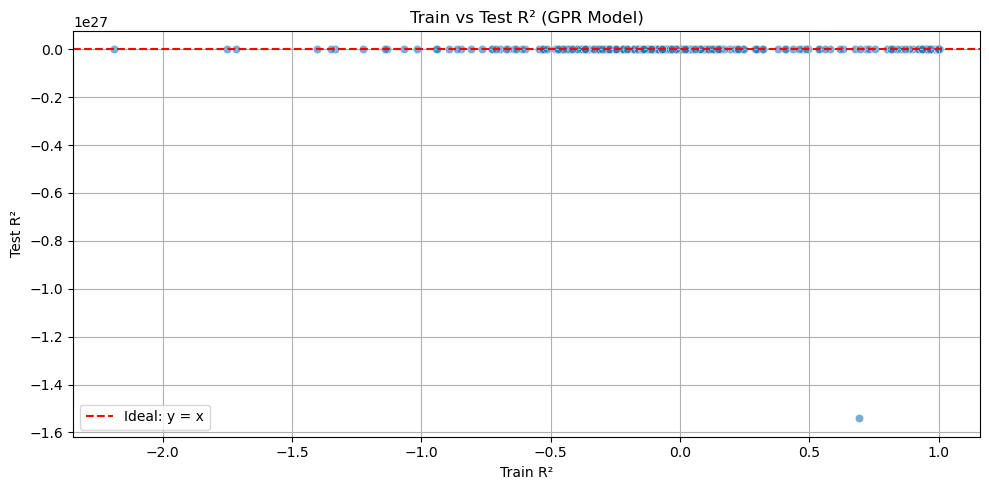

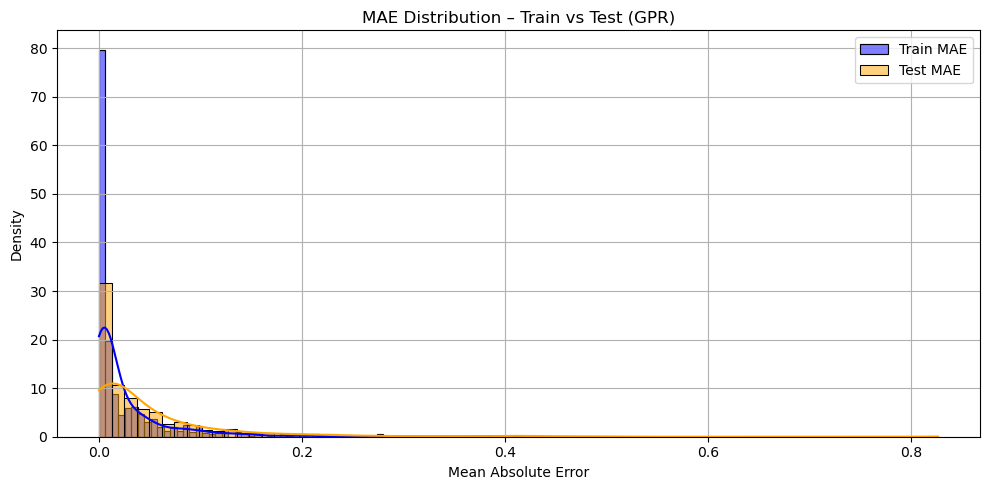

C:\Users\adire\AppData\Local\Temp\ipykernel_23136\2652593429.py:69: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\adire\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


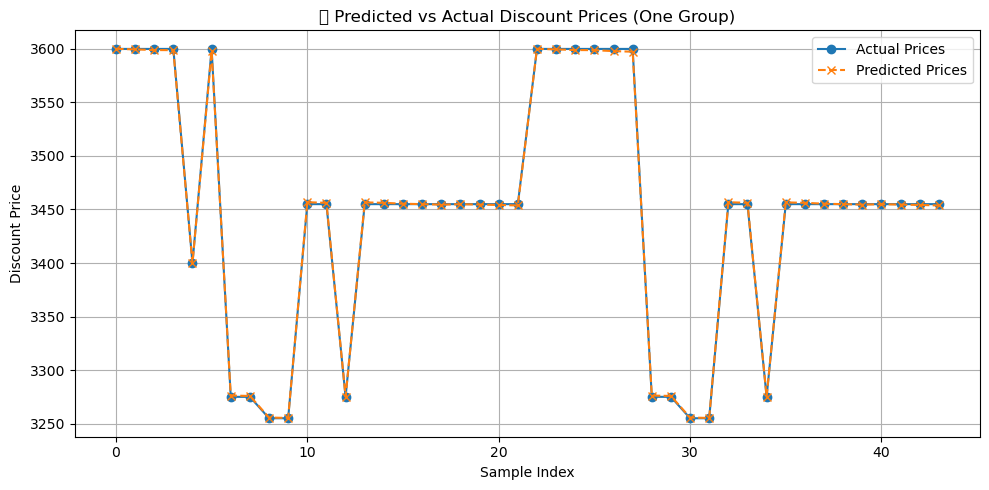

In [89]:
# Cell 12: Analyze GPR Results – Summary & Visual Comparison

# --- Ensure results dataframe exists ---
assert 'gpr_results_df' in globals(), "❌ gpr_results_df not found. Please run the GPR modeling cell first."

# --- Summary Statistics ---
avg_train_r2 = gpr_results_df['Train R²'].mean()
avg_test_r2 = gpr_results_df['Test R²'].mean()
avg_train_mae = gpr_results_df['Train MAE'].mean()
avg_test_mae = gpr_results_df['Test MAE'].mean()

print("📊 GPR Model Performance Summary:")
print(f"🔹 Average Train R²: {avg_train_r2:.4f}")
print(f"🔹 Average Test  R²: {avg_test_r2:.4f}")
print(f"🔹 Average Train MAE: {avg_train_mae:.4f}")
print(f"🔹 Average Test  MAE: {avg_test_mae:.4f}")

# --- Split results by test R² ---
good_models = gpr_results_df[gpr_results_df['Test R²'] >= 0].copy()
bad_models = gpr_results_df[gpr_results_df['Test R²'] < 0].copy()

print(f"\n✅ Good models: {len(good_models)}")
print(f"❌ Bad models : {len(bad_models)}")

# --- Summary Table (Good vs Bad) ---
numeric_cols = ['Train R²', 'Test R²', 'Train MAE', 'Test MAE', 'Train Size', 'Test Size', 'Samples Used']
good_stats = good_models[numeric_cols].describe().T
bad_stats = bad_models[numeric_cols].describe().T

comparison = pd.concat([good_stats[['mean', 'std']], bad_stats[['mean', 'std']]], axis=1)
comparison.columns = ['Good Mean', 'Good Std', 'Bad Mean', 'Bad Std']

print("\n📈 Statistical Comparison Between Good and Bad GPR Models:")
display(comparison)

# --- R² Train vs Test Plot ---
plt.figure(figsize=(10, 5))
sns.scatterplot(data=gpr_results_df, x='Train R²', y='Test R²', alpha=0.6)
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Ideal: y = x')
plt.title('Train vs Test R² (GPR Model)')
plt.xlabel('Train R²')
plt.ylabel('Test R²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- MAE Distributions ---
plt.figure(figsize=(10, 5))
sns.histplot(gpr_results_df['Train MAE'], color='blue', label='Train MAE', kde=True, stat='density')
sns.histplot(gpr_results_df['Test MAE'], color='orange', label='Test MAE', kde=True, stat='density')
plt.title('MAE Distribution – Train vs Test (GPR)')
plt.xlabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Visual Example: Predicted vs Actual on a Single Group (from Cell 9) ---
if 'result' in globals() and 'original_subset' in globals():
    plt.figure(figsize=(10, 5))
    plt.plot(original_subset['Discount Price'].values, label='Actual Prices', marker='o')
    plt.plot(result['final_predictions'], label='Predicted Prices', linestyle='--', marker='x')
    plt.title('📈 Predicted vs Actual Discount Prices (One Group)')
    plt.xlabel('Sample Index')
    plt.ylabel('Discount Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Skipping visual plot for one group – run Cell 9 first.")


In [ ]:
# Cell 13: Evaluate GPR on test set (structure only, no output or plots)

def evaluate_gpr_on_test_set(grouped_df, train_df, test_df):
    results = []

    for _, row in tqdm(grouped_df.iterrows(), total=grouped_df.shape[0], desc="🧪 Evaluating GPR on test set"):
        hotel = row['Hotel Name']
        snapshot_date = pd.to_datetime(row['Snapshot Date'])
        discount_code = row['Discount Code']

        # Filter training group
        train_group = train_df[
            (train_df['Hotel Name'] == hotel) &
            (pd.to_datetime(train_df['Snapshot Date']) == snapshot_date) &
            (train_df['Discount Code'] == discount_code)
        ].copy()

        if train_group.shape[0] < 5:
            continue

        # Filter test group
        test_group = test_df[
            (test_df['Hotel Name'] == hotel) &
            (pd.to_datetime(test_df['Snapshot Date']) == snapshot_date) &
            (test_df['Discount Code'] == discount_code)
        ].copy()

        if test_group.shape[0] < 3:
            continue

        feature_cols = [
            'Checkin_Ordinal', 'Weekday_Num', 'Available Rooms',
            'DayDiff', 'Original Price', 'DiscountDiff', 'DiscountPerc'
        ]
        selected_features = [f for f in feature_cols if f in train_group.columns]

        X_train = train_group[selected_features]
        y_train = train_group['Discount Price']

        X_test = test_group[selected_features]
        y_test = test_group['Discount Price']

        try:
            kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, normalize_y=True)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
        except Exception as e:
            r2 = None

        results.append({
            'Hotel Name': hotel,
            'Snapshot Date': snapshot_date,
            'Discount Code': discount_code,
            'Test Size': len(y_test),
            'R2 GPR Test Score': r2
        })

    return pd.DataFrame(results)

# Run evaluation
gpr_test_results = evaluate_gpr_on_test_set(grouped, train_df, test_df)

🧪 Evaluating GPR on test set: 100%|██████████| 7503/7503 [04:56<00:00, 25.34it/s]


📊 GPR Test Set – Average R²: -264357809215807554599205732352.0000
📉 GPR Test Set – R² Standard Deviation: 8520349405544463463071971540992.0000
✅ Total Groups Evaluated: 1166


,Hotel Name,Snapshot Date,Discount Code,Test Size,R2 GPR Test Score
0,Park Hyatt New York,2015-07-22,2,14,0.990598
1,The New York EDITION,2015-07-27,2,6,0.990767
2,The New York EDITION,2015-07-29,3,5,0.965116
3,The New York EDITION,2015-07-29,2,7,0.996044
4,Newark Liberty International Airport Marriott,2015-07-23,3,4,0.831519


C:\Users\adire\AppData\Local\Temp\ipykernel_21328\2232398770.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_r2, x='Set', y='R2 Score', palette='Set2')


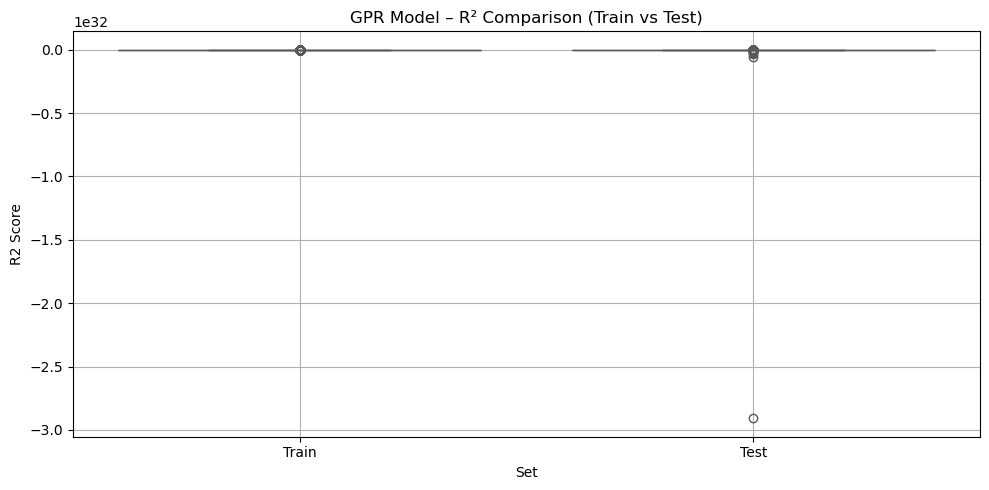

In [ ]:
# Cell 14: GPR Test Set – Summary Statistics

# Drop any NaNs in case of failed model fits
gpr_test_results_clean = gpr_test_results.dropna(subset=['R2 GPR Test Score']).copy()

# Average R²
mean_r2_test_gpr = gpr_test_results_clean['R2 GPR Test Score'].mean()
std_r2_test_gpr = gpr_test_results_clean['R2 GPR Test Score'].std()

# Output stats
print(f"📊 GPR Test Set – Average R²: {mean_r2_test_gpr:.4f}")
print(f"📉 GPR Test Set – R² Standard Deviation: {std_r2_test_gpr:.4f}")
print(f"✅ Total Groups Evaluated: {len(gpr_test_results_clean)}")

# Preview first rows
display(gpr_test_results_clean.head())


# 📈 Visualize Train vs Test R² Distributions (GPR)

# Drop NaNs
train_r2 = gpr_results_df['R2 Score'].dropna()
test_r2 = gpr_test_results_clean['R2 GPR Test Score'].dropna()

# Create combined DataFrame for seaborn
combined_r2 = pd.DataFrame({
    'R2 Score': pd.concat([train_r2, test_r2], ignore_index=True),
    'Set': ['Train'] * len(train_r2) + ['Test'] * len(test_r2)
})

# Plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined_r2, x='Set', y='R2 Score', palette='Set2')
plt.title('GPR Model – R² Comparison (Train vs Test)')
plt.grid(True)
plt.tight_layout()
plt.show()


### 4.9 - 

In [ ]:
# Cell 15: Export Results & Summary

# Export results to CSV
results_df.to_csv("Output/base_model_results.csv", index=False)
gpr_results_df.to_csv("Output/gpr_model_results.csv", index=False)

# Summary print
print("✅ Export complete. Results saved to 'Output' folder.\n")

print("📊 Final Summary:")
print(f"- Base Model: {results_df.shape[0]} models | Avg R² = {results_df['R2 Score'].mean():.4f}")
print(f"- GPR Model : {gpr_results_df.shape[0]} models | Avg R² = {gpr_results_df['R2 Score'].mean():.4f}")

# Optional: show head of each file
print("\n📄 Base Model Preview:")
display(results_df.head())

print("\n📄 GPR Model Preview:")
display(gpr_results_df.head())

OSError: Cannot save file into a non-existent directory: 'Output'